In [4]:
from keras.preprocessing.image import Iterator
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.utils.np_utils import convert_kernel

import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import csv
import random
import h5py
from PIL import Image

In [ ]:
with open('data/driving_log.csv') as csvfile:
        reader = csv.DictReader(csvfile)
        rows = list(reader)
angles = []

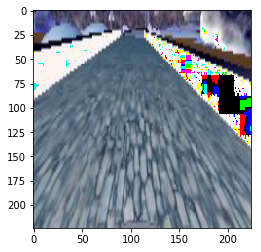

In [19]:
from keras.preprocessing.image import load_img, img_to_array
x = Image.open('data/IMG/center_2016_12_01_13_32_52_146.jpg')
x = x.crop((0,55,320,140))
x = x.resize((224,224), resample=Image.BILINEAR)
x = np.asarray(x)
mean_pixel = [103.939, 116.779, 123.68]
x = x.astype(np.float32, copy=False)
# for c in range(3):
#     x[:, :, c] = x[:, :, c] - mean_pixel[c]
plt.imshow(x)

In [3]:


def save_bottlebeck_features():
    # build the VGG16 network
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape=(85, 320, 3)))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    weights_path = 'data/vgg16_weights.h5'
    f = h5py.File('data/vgg16_weights.h5')
    for k in range(f.attrs['nb_layers']):
        if k >= len(model.layers) - 1:
            # we don't look at the last two layers in the savefile (fully-connected and activation)
            break
        g = f['layer_{}'.format(k)]
        weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
        layer = model.layers[k]

        if layer.__class__.__name__ in [
                'Convolution1D', 'Convolution2D', 'Convolution3D', 'AtrousConvolution2D']:
            weights[0] = np.transpose(weights[0], (2, 3, 1, 0))

        layer.set_weights(weights)

    f.close()

    with open('data/driving_log.csv') as csvfile:
        reader = csv.DictReader(csvfile)
        rows = list(reader)

    random.seed(0)
    random.shuffle(rows)
    split = int(len(rows)/10)

    print("Creating training bottleneck features.")
    train_set = rows[split:]
    bottleneck_features_train = model.predict_generator(data_generator(train_set), len(train_set))
    np.save(open('bottleneck_features_train.npy', 'wb'), bottleneck_features_train)
    
    print("Creating validation bottleneck features.")
    validation_set = rows[:split]
    bottleneck_features_validation = model.predict_generator(data_generator(validation_set), len(validation_set))
    np.save(open('bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)

def preprocess(image):
    # Convert to grayscale.
    # image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
#     image = image.astype(float)
#     # image = np.expand_dims(image, axis=2)
#     # Subtract the mean.
#     image -= np.mean(image)
#     # Normalize.
#     image /= (np.std(image) + 1e-7)
    # Crop hood and horizon out of image.
    image = image[55:140][:][:]
    return image

def data_generator(rows):
    iterator = Iterator(len(rows), batch_size=32, shuffle=True, seed=None)
    for index_array, _, batch_size in iterator.index_generator:
        batch_x = np.zeros((batch_size, 85, 320, 3))
        batch_y = np.zeros((batch_size, 1))
        for idx, index in enumerate(index_array):
            row = rows[index]
            image = mpimg.imread('data/'+row['center'])
            batch_x[idx] = preprocess(image)
            batch_y[idx] = row['steering']
        yield (batch_x, batch_y)

In [4]:
save_bottlebeck_features()

Creating training bottleneck features.
Creating validation bottleneck features.


In [7]:
def train_top_model():
    with open('data/driving_log.csv') as csvfile:
        reader = csv.DictReader(csvfile)
        rows = list(reader)

    random.seed(0)
    random.shuffle(rows)
    split = int(len(rows)/10)
    
    train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
    train_labels = np.array([row['steering'] for row in rows[split:]])

    validation_data = np.load(open('bottleneck_features_validation.npy', 'rb'))
    validation_labels = np.array([row['steering'] for row in rows[:split]])

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))

    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

    model.fit(train_data, train_labels,
              nb_epoch=2, batch_size=32,
              validation_data=(validation_data, validation_labels))
    model.save_weights(top_model_weights_path)

In [8]:
train_top_model()

Train on 7233 samples, validate on 803 samples
Epoch 1/2
7233/7233 [==============================] - 5s - loss: 236.5760 - acc: 0.5050 - val_loss: 0.0232 - val_acc: 0.5293

NameError: name 'top_model_weights_path' is not defined